# IMPORTING LIBRARIES AND DEFINITIONS

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import time 

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

dataset_path = "dataset"
train_dir = 'dataset/train'
validation_dir = 'dataset/test'
model_dir = 'modelcp'

# BATCH_SIZE = 16
BATCH_SIZE = 20
IMG_WIDTH = 448
IMG_HEIGHT = 448

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values for validation images

# Load and preprocess the training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Resize all images to 224x224
    batch_size=BATCH_SIZE,  # Number of images to process in each batch
    class_mode='categorical'  # Return labels as one-hot encoded vectors
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [4]:
def create_model(summary=True):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add L2 regularization
    x = Dropout(0.5)(x)  # Add Dropout layer
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Optional additional Dense layer with L2
    x = Dropout(0.5)(x)  # Add Dropout layer
    predictions = Dense(4, activation='softmax')(x)  # Two output neurons for "defect" and "no defect"

    # Combine the base model and the custom layers into a final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Keep all layers trainable
    for layer in base_model.layers:
        layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1.0e-5)  # Reduce the learning rate
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if summary:
        print(model.summary())
    return model

In [5]:
if not os.path.exists(model_dir):
        os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'lviv_no_defect',
 1: 'open_lviv_box',
 2: 'open_wfl_cover',
 3: 'wfl_no_defect'}

In [6]:
# model = create_model()

# training_start_time = time.time()

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     epochs=20,  # Number of epochs to train the model
#     callbacks=[cp_callback]  
# )

# training_end_time = time.time()
# total_training_time = training_end_time - training_start_time
# print(f"Total training time: {total_training_time: .2f} seconds")

# # After training, extract final metrics from the history
# final_train_acc = history.history['accuracy'][-1]
# final_val_acc = history.history['val_accuracy'][-1]
# final_train_loss = history.history['loss'][-1]
# final_val_loss = history.history['val_loss'][-1]

# # Print the final metrics
# print(f"Final training accuracy: {final_train_acc * 100:.2f}%")
# print(f"Final validation accuracy: {final_val_acc * 100:.2f}%")
# print(f"Final training loss: {final_train_loss:.4f}")
# print(f"Final validation loss: {final_val_loss:.4f}")

# # Save the metrics in a text file
# with open("model_metrics.txt", "w") as f:
#     f.write(f"Final training accuracy: {final_train_acc * 100:.2f}%\n")
#     f.write(f"Final validation accuracy: {final_val_acc * 100:.2f}%\n")
#     f.write(f"Final training loss: {final_train_loss:.4f}\n")
#     f.write(f"Final validation loss: {final_val_loss:.4f}\n")
#     f.write(f"Total training time: {total_training_time: .2f} seconds\n")

In [7]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# epochs = range(1, len(acc) + 1)

# plt.figure(figsize=(12, 6))
# plt.plot(epochs, acc, 'b', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()

# plt.savefig("accuracy.png")
# plt.show()

In [8]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(12, 6))
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()

# plt.savefig("loss.png")
# plt.show()

In [9]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a new model instance
loaded_model = create_model(summary=True)

# Load the previously saved weights
loaded_model.load_weights(latest)

loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [48]:
def show_img(img_array, title):
    plt.title(title)
    plt.imshow(img_array)
    plt.axis("off")
    
    plt.savefig("plot/overlay.png", format="png", dpi=300)
    plt.show()

In [11]:
def make_gradcam_heatmap_actual(img_array, model, last_conv_layer_name, pred_index=None):
        
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print("hello")
            print(pred_index.numpy())
            print("bye")
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap)

    if pred_index.numpy() == 0 or pred_index.numpy() == 3: 
        heatmap = tf.zeros_like(heatmap)

    elif pred_index.numpy() == 2: 
        if max_val > 0.05: 
            heatmap = tf.where(heatmap<0.05, 0, heatmap)
            heatmap = heatmap / max_val
        else: 
            heatmap = tf.zeros_like(heatmap)
    elif pred_index.numpy() == 1:
        if max_val < 0.05: 
            heatmap = tf.where(heatmap>0.05, 0, heatmap)
            heatmap = heatmap / max_val
        else: 
            heatmap = tf.zeros_like(heatmap)

    print("Max value in heatmap: ", max_val.numpy())

    return heatmap.numpy()

In [49]:
def make_gradcam_heatmap_draft(img_array, model, last_conv_layer_name, pred_index=None):
        
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        probabilities = tf.nn.softmax(preds[0])
        for index, prob in enumerate(probabilities):
            print(f"Class: {index}, Probability: {prob.numpy():.4f}")

        pred_index = tf.argmax(preds[0])
        print(pred_index.numpy())
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)

    max_val = tf.math.reduce_max(heatmap)
    heatmap = heatmap / max_val

    plt.imshow(heatmap, cmap="seismic")
    plt.colorbar()
    plt.title("Heatmap")

    plt.savefig("plot/heatmap.png", format="png", dpi=300)
    plt.show()

    # if pred_index.numpy() == 0 or pred_index.numpy() == 3: 
    #     heatmap = tf.zeros_like(heatmap)

    # elif pred_index.numpy() == 2: 
    #     if max_val > 0.05: 
    #         heatmap = tf.where(heatmap<0.05, 0, heatmap)
    #         heatmap = heatmap / max_val
    #     else: 
    #         heatmap = tf.zeros_like(heatmap)
    # elif pred_index.numpy() == 1:
    #     if max_val < 0.05: 
    #         heatmap = tf.where(heatmap>0.05, 0, heatmap)
    #         heatmap = heatmap / max_val
    #     else: 
    #         heatmap = tf.zeros_like(heatmap)

    print("Max value in heatmap: ", max_val.numpy())

    return heatmap.numpy()

In [13]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # print(superimposed_img)
    # Display Grad CAM
    show_img(superimposed_img, 'IMAGE OUT: Grad-CAM')

ACTUAL LABEL: WFL DEFECT


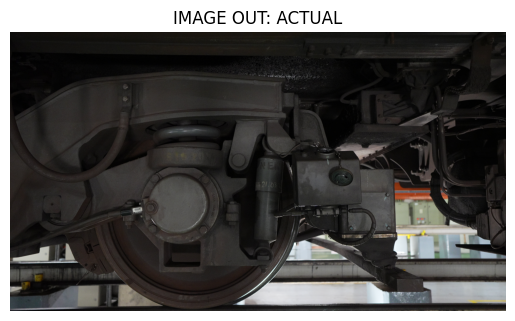

1/1 [==============================] - 0s 19ms/step
Class: 0, Probability: 0.1749
Class: 1, Probability: 0.1749
Class: 2, Probability: 0.4753
Class: 3, Probability: 0.1749
PRED LABEL: WFL DEFECT
Class: 0, Probability: 0.0001
Class: 1, Probability: 0.0001
Class: 2, Probability: 0.9997
Class: 3, Probability: 0.0002
2


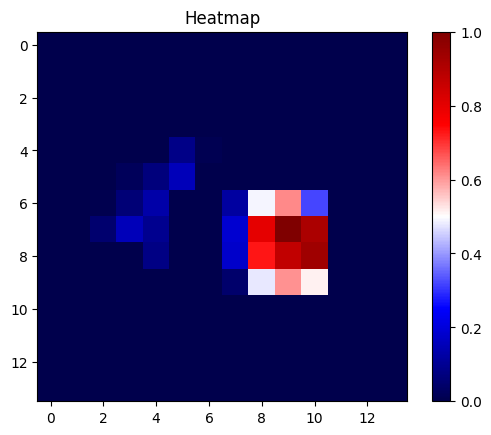

Max value in heatmap:  0.06889854


C:\Users\admin\AppData\Local\Temp\ipykernel_34204\3559981182.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


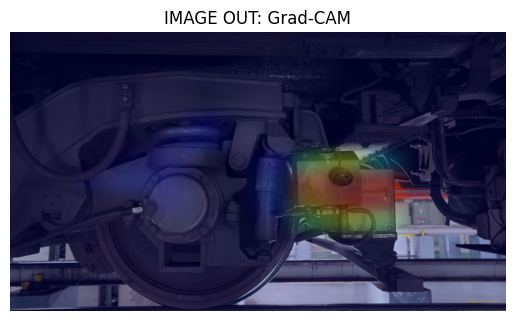

2

In [50]:
def make_prediction_and_visualize():
    val_path = dataset_path + '/test'

    # Randomly choose a class for the test
    class_idx = np.random.randint(0, 4)

    label_mapping = {
        0: ('lviv_no_defect', 'NO LVIV DEFECT'),
        1: ('open_lviv_box', 'LVIV DEFECT'),
        2: ('open_wfl_cover', 'WFL DEFECT'),
        3: ('wfl_no_defect', 'NO WFL DEFECT')
        # Add more mappings if needed
    }

    folder, actual_label = label_mapping[class_idx]
    print(f'ACTUAL LABEL: {actual_label}')
    
    folder = os.path.join(val_path, folder)

    img_paths = os.listdir(folder)
    folder_size = len(img_paths)
    idx = np.random.randint(0, folder_size)
    img_path = folder + '/' + img_paths[idx]
    #os.path.join(folder, img_paths[idx])
    img = cv2.imread(img_path)
    show_img(img[:,:,[2,1,0]], 'IMAGE OUT: ACTUAL')
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    rescaled_img = img/255.0
    
    batch_pred = np.expand_dims(rescaled_img, 0)
    logits = loaded_model.predict(batch_pred)
    probabilities = tf.nn.softmax(logits[0])
    for index, prob in enumerate(probabilities):
        print(f"Class: {index}, Probability: {prob.numpy():.4f}")

    pred = np.argmax(logits[0])

    predicted_label = list(label_mapping.values())[pred][1]
    print(f'PRED LABEL: {predicted_label}')

    last_conv_layer_name = 'conv5_block3_out'

    # heatmap_actual = make_gradcam_heatmap_actual(batch_pred, loaded_model, last_conv_layer_name)
    # save_and_display_gradcam(img_path, heatmap_actual)

    heatmap_draft = make_gradcam_heatmap_draft(batch_pred, loaded_model, last_conv_layer_name)    
    save_and_display_gradcam(img_path, heatmap_draft)
    
    return pred

make_prediction_and_visualize()